## Problem Statement

To build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, we will map each ticket onto its respective department/category. Then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

Following major tasks are done as part of this assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference



### *   By Sirin Shaikh



## Importing the necessary libraries

In [219]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
# Libraries for text preprocessing and analysis
import re,nltk,spacy,string
nlp=spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
!pip install -U textblob
!python -m textblob.download_corpora


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [220]:
import pathlib
import os
from google.colab import drive
drive.mount('/content/gdrive')
base_dir = pathlib.Path('/content/gdrive/My Drive/nlp01')
os.chdir(str(base_dir))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [221]:
!ls

Automatic_Ticket_Classification_Assignment.ipynb  complaints-2021-05-14_08_16.json


In [222]:
with open('complaints-2021-05-14_08_16.json', 'r') as f:
    # Load the JSON data as a dictionary
    data = json.load(f)

# Normalize the JSON data into a flat table
df = pd.json_normalize(data)

## Data preparation

In [223]:
# Inspect the dataframe to understand the given data.
# Display the first few rows of the dataframe
print(df.head())

                _index      _type      _id  _score   _source.tags _source.zip_code _source.complaint_id                       _source.issue      _source.date_received _source.state _source.consumer_disputed              _source.product _source.company_response       _source.company _source.submitted_via _source.date_sent_to_company _source.company_public_response                         _source.sub_product _source.timely                                                                                                                                                                                                                                                                                                                                                                                                                                                                             _source.complaint_what_happened                                 _source.sub_issue _source.consumer_consent_provided

In [224]:
df.shape

(78313, 22)

In [225]:
#print the column names
col_list = list(df.columns)
print(col_list)

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [227]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0




*   _score is the only numeric column and has all values as 0.0



In [228]:
# Inspect the number of missing values percentage
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened       0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [229]:
# There are many blank rows in '_source.complaint_what_happened'. Converting them into NaN values
df['_source.complaint_what_happened'].replace("", np.nan, inplace=True)

In [230]:
# Inspecting the number of missing values percentage again
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened      73.09
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

- `_source.complaint_what_happened` has 73.09 % of null values. Need to remove them

In [231]:
#Dropping NaN rows from "_source.complaint_what_happened"
df.dropna(subset=['_source.complaint_what_happened'], inplace=True)

#New shape of df
df.shape

(21072, 22)

In [232]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [233]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported i

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [234]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()

    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)

    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text

In [235]:
#Cleaning df['complaint_what_happened']
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [236]:
#Write your function to Lemmatize the texts
def lemma_texts(text):

    # Initialize empty list to store lemmas
    lemma_list = []

    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [237]:
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_texts(x['complaint_what_happened']), axis=1)

# View the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided,"chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant ."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen t

In [238]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [239]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant ."
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while try to book a xxxx xxxx ticket , I come across an offer for { $ . } to be apply towards the ticket if I apply for a reward card . I put in my information for the offer and within less than a minute , be notify via the screen that a decision could not be make . I immediately contact xxxx and be refer to chase bank . I then immediately contact ch

To find the topics of the complaints, we only need singular nouns.


In [240]:
#Write your function to extract the POS tags
# Extracting singular nouns
def singular_nouns(text):


    # Creating a textblob object
    text_blob = TextBlob(text)

    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

In [241]:
# "complaint_POS_removed" column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
# Applying the function to create a new column containing only singular nouns
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: singular_nouns(x['lemmatized_complaint']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , 

In [242]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , 

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [243]:
#lenght of character in 'complaint_POS_removed'
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]

[159, 101, 67, 414, 155, 7, 650, 582, 1172, 51]

In [244]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , 

Text(0, 0.5, 'No. of Complaints')

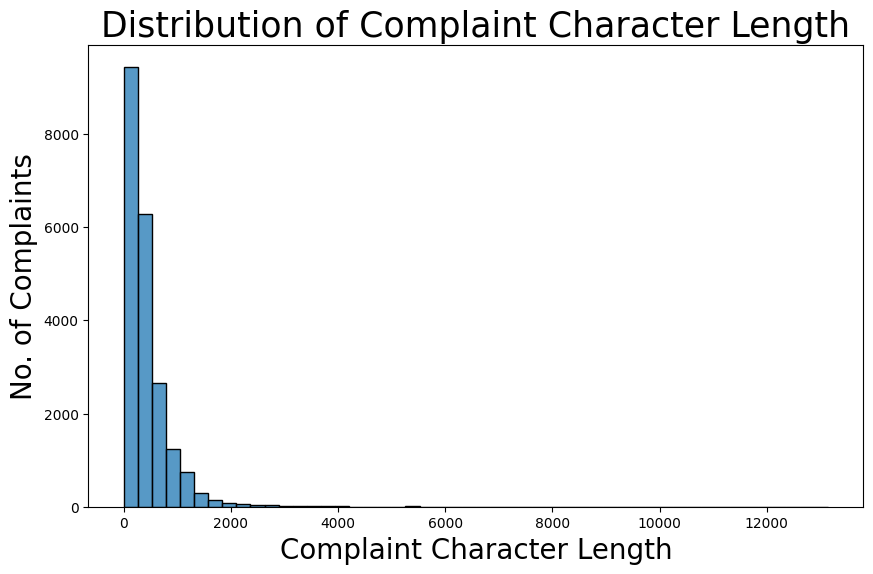

In [245]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

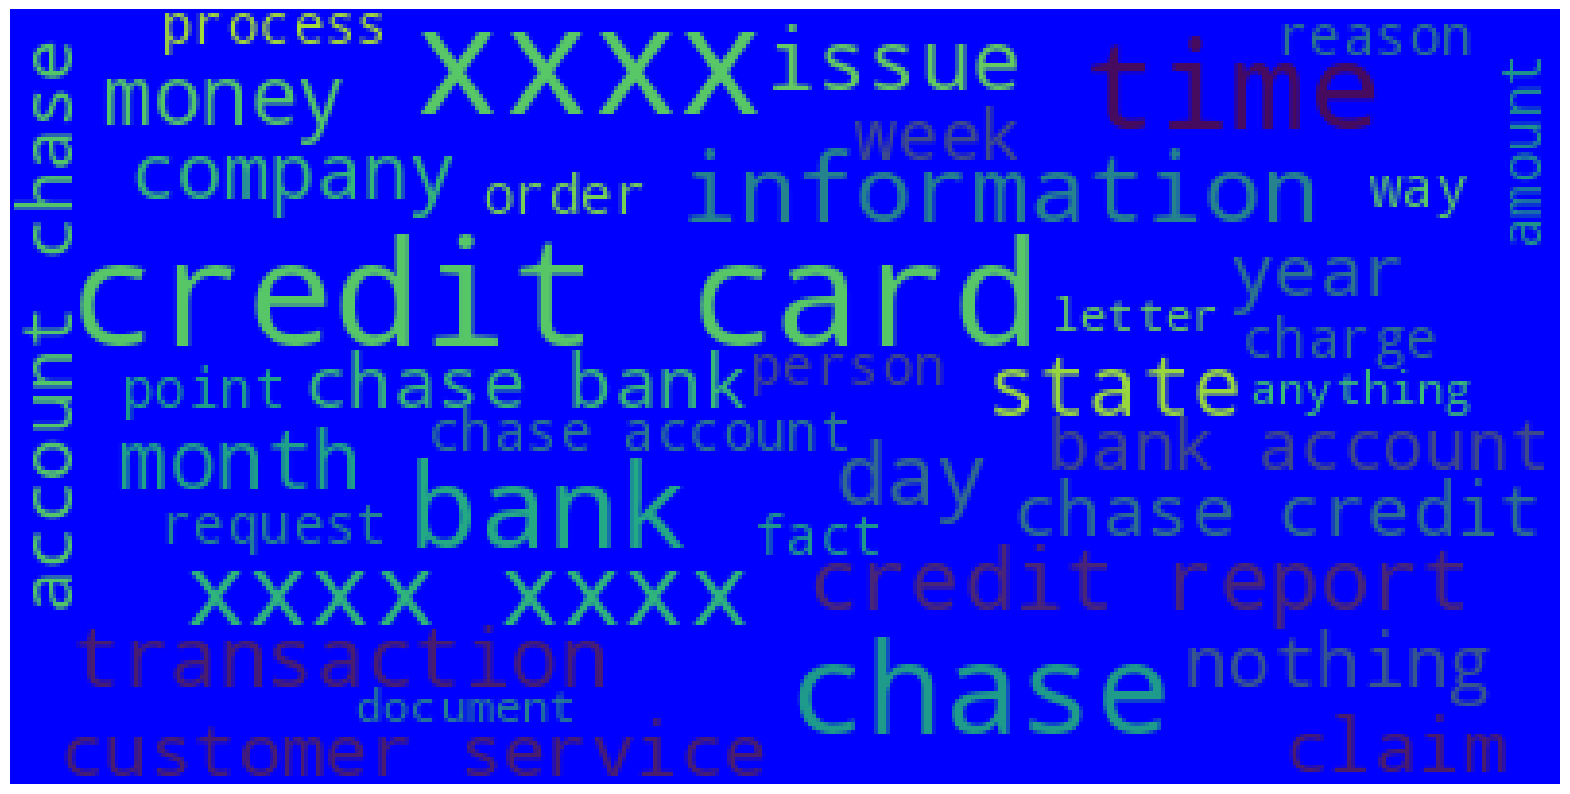

In [246]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='blue',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [247]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [248]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,49212
1,account,47913
2,xxxx,43304
3,credit,34300
4,card,29633
5,bank,28503
6,payment,21338
7,time,16281
8,charge,15153
9,day,13073


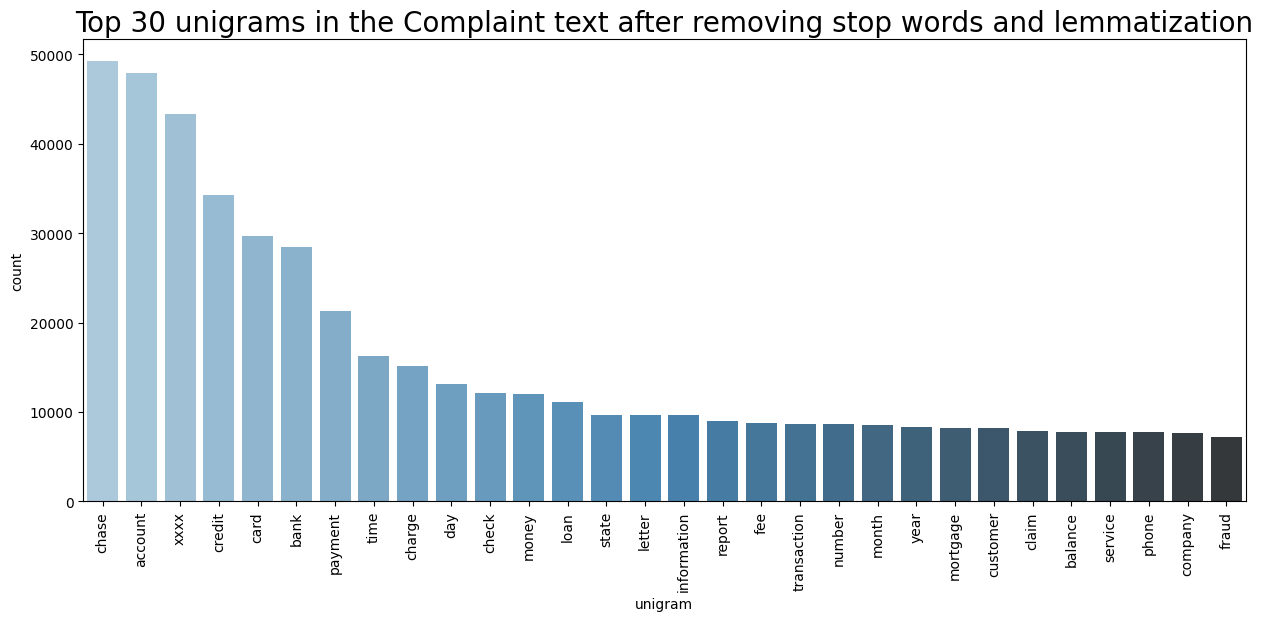

In [249]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [250]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [251]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12878
1,xxxx xxxx,6249
2,credit report,3964
3,customer service,3082
4,chase credit,3064
5,chase bank,2935
6,account chase,2761
7,bank account,2751
8,chase account,2718
9,account account,2307


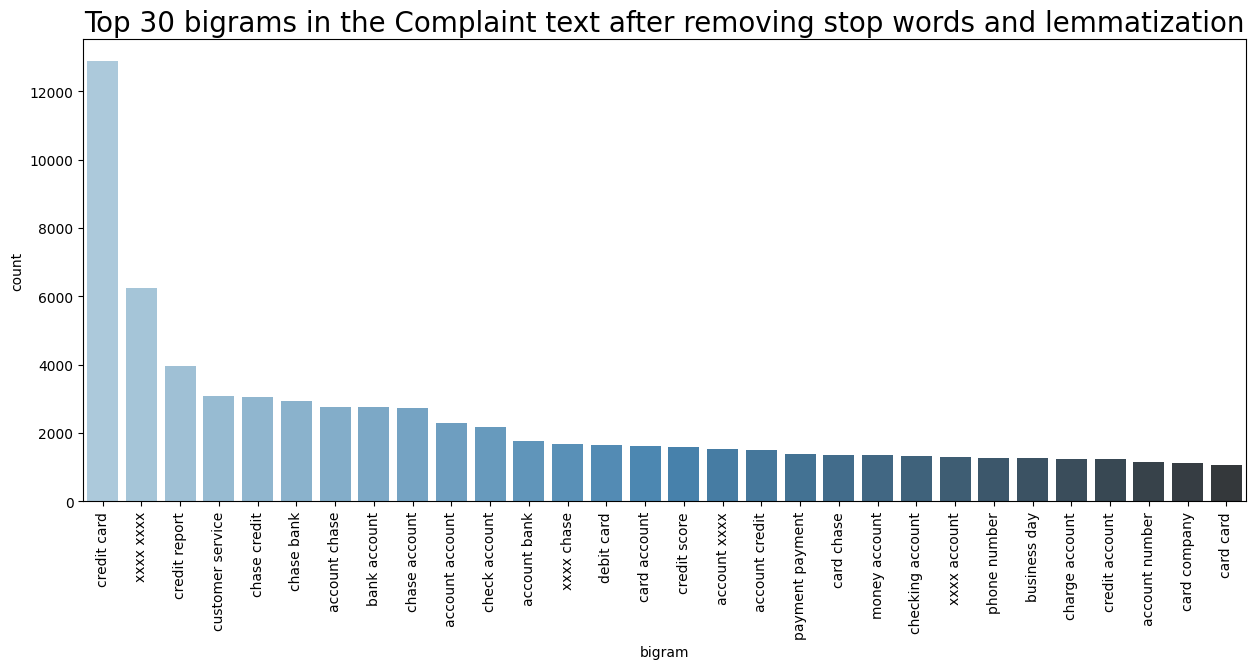

In [252]:
# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()


In [253]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [254]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2140
1,xxxx xxxx xxxx,1063
2,credit card account,1056
3,credit card company,995
4,credit card chase,673
5,credit card credit,506
6,inquiry credit report,483
7,charge credit card,430
8,account credit card,414
9,card credit card,382


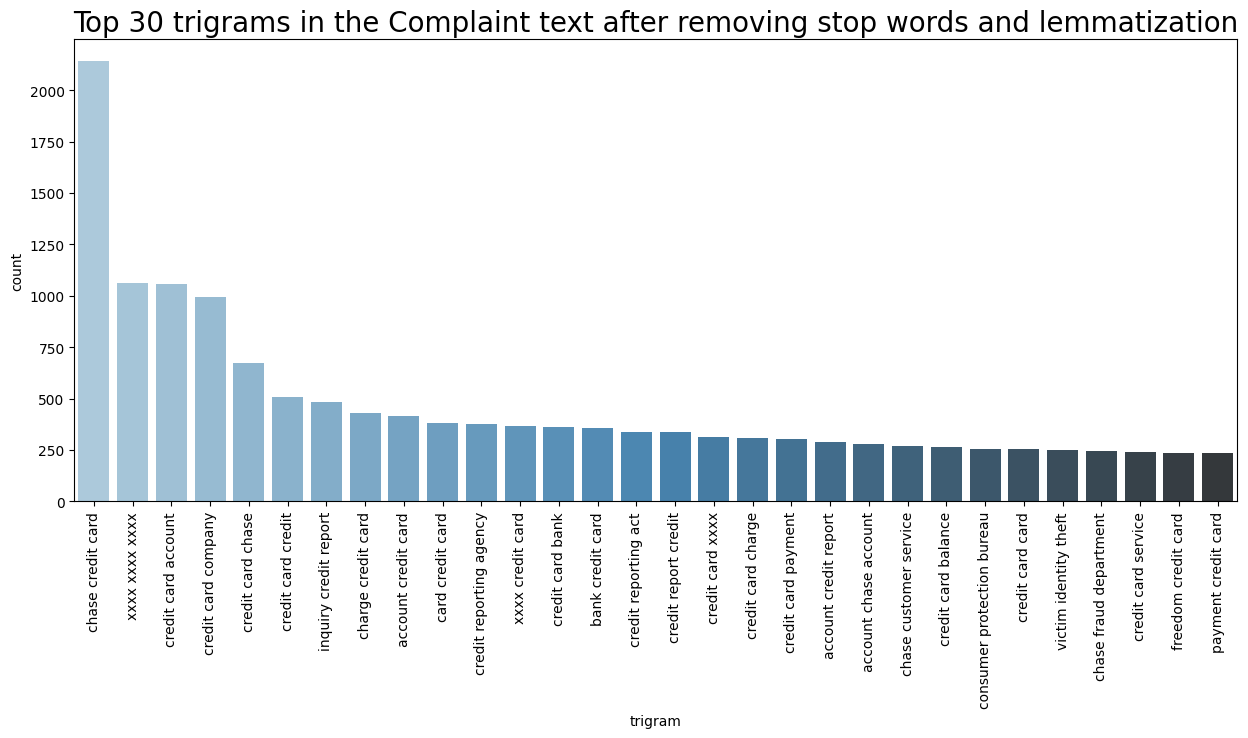

In [255]:
# Plot the top 30 trigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [256]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [257]:
df_clean.shape

(21072, 3)

In [258]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while try 

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [259]:
#Write your code here to initialise the TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [260]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [261]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

Using Coherence Model to select best number of Topics.

In [262]:
#Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
data_set = [x.split() for x in texts]

# Creating a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(data_set)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in data_set]

# Create a list of the topic numbers we want to try
topic_num = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )

    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append(round(coherence_model.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_num, coherence_scores))
num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(num_topics)

5


In [263]:
df_clean.shape

(21072, 3)

In [264]:
# Making a copy of df_clean incase any error occurs
df_cleanx =df_clean.copy()

In [265]:
#Load your nmf_model with the n_components i.e 5

#keep the random_state =40
nmf_model = NMF(n_components=5,random_state=40)

In [266]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7077

In [267]:
# Print the top word of a sample component
topic_single = nmf_model.components_[0]
topic_single.argsort()
top_word_index = topic_single.argsort()[-10:]
for index in top_word_index:
    print(tfidf.get_feature_names_out()[index])

number
day
branch
deposit
chase
fund
money
bank
check
account


In [268]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'account', 'credit', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']


TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'dispute', 'transaction', 'fee', 'chase', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['sale', 'house', 'foreclosure', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [269]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [270]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)

In [271]:
df_clean.shape

(21072, 4)

In [272]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ 

In [273]:
df_clean.shape

(21072, 4)

In [274]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,my grand son give I check for { $ . } I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen xx / xx/ check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date number claim number chase,0
17,"with out notice j.p. morgan chase restricted my account by my debit card tuesday xx/xx/. on thursday xx/xx/ i went into a branch after being advised by a customer service representative that my account would actually be closed. i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day. that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday, xx/xx/. upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement. ive been called and i was told that it may take two business day stating tuesday, xx/xx/xxxx would be the date that my funds would be available to withdraw from a bank teller only. now, chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. unfortunately, this has put me in an additional financial bind do two fees from late rent late car payments, etc. i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally. thank you","with out notice j.p . morgan chase restrict my account by my debit card tuesday xx / xx/. on thursday xx / xx/ I go into a branch after be advise by a customer service representative that my account would actually be close . I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return . the bank associate and the customer service representative assure I that the fund would post but they may take an additional business day . that saturday I attempt to go inside of a bran

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [275]:
df_clean.shape

(21072, 4)

In [276]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [277]:
df_clean.shape

(21072, 4)

In [278]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application w

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [279]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [280]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ 

In [281]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [285]:
training_data.shape

(21072, 2)

In [286]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.",1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.",1
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,0


In [287]:
# View value counts of the five topics
training_data['Topic'].value_counts()

Topic
0    5168
1    4954
3    4860
4    3808
2    2282
Name: count, dtype: int64

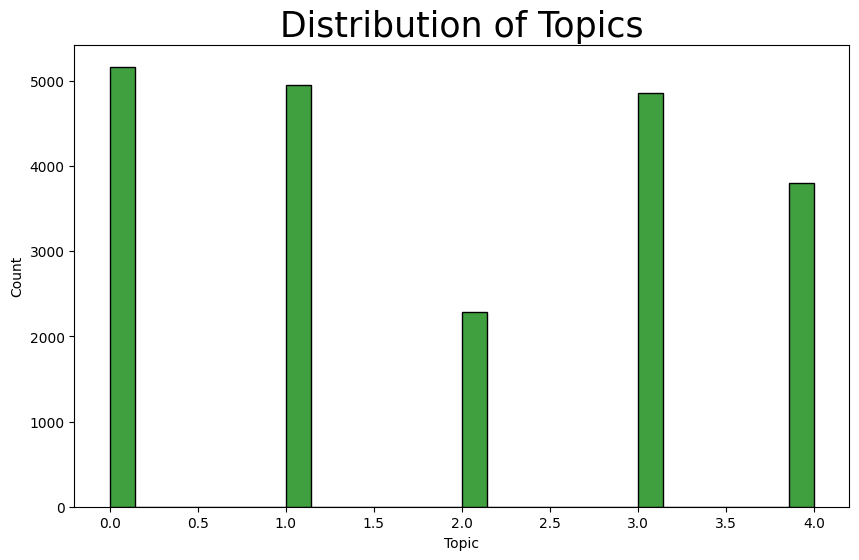

In [288]:
# Plotting a histogram of topics
plt.figure(figsize=[10,6])
sns.histplot(data=training_data, x='Topic',color='Green', )
plt.title("Distribution of Topics", fontsize=25)
plt.show()

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [289]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

In [290]:
# Saving Word Vector on disk for later usage
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [291]:
# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [292]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [293]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [294]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):

    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

    return

## Model:1 - Naive-Bayes

In [295]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Import required library
from sklearn.naive_bayes import MultinomialNB

In [296]:
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [297]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb,
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [298]:
# Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [299]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.7792158040677712

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.80      1305
Credit card or prepaid card       0.80      0.75      0.78      1265
                     Others       0.66      0.63      0.65       563
    Theft/Dispute Reporting       0.77      0.77      0.77      1222
              Mortgage/Loan       0.83      0.85      0.84       913

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



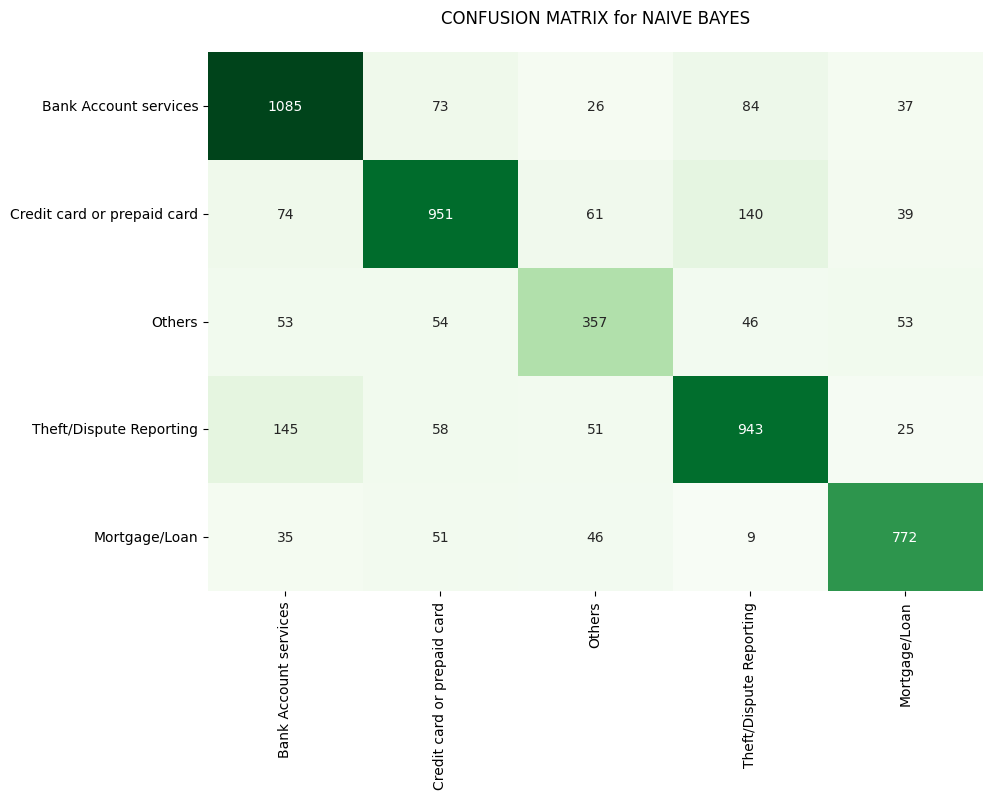

In [300]:
# Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb_tuned, model_name)

In [301]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score': round(f1_nb, 2)}])
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78


## Model:2 - Logistic Regression

In [303]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [304]:
# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [305]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [306]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1,
                                  penalty='l1',
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [307]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9429908817667709

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1305
Credit card or prepaid card       0.95      0.95      0.95      1265
                     Others       0.94      0.95      0.94       563
    Theft/Dispute Reporting       0.94      0.91      0.93      1222
              Mortgage/Loan       0.94      0.95      0.94       913

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



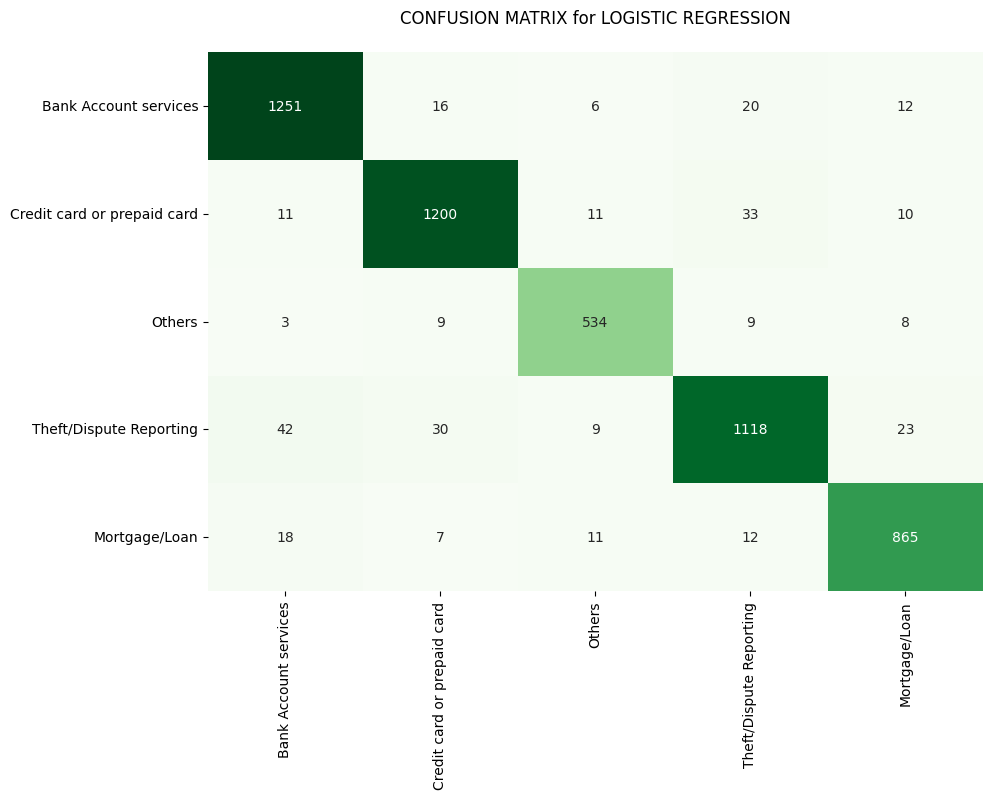

In [308]:
model_eval(y_test, y_pred_lr_tuned, model_name)

In [309]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Logistic Regression', round(f1_lr, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.94


### Model:3 - Decision Tree

In [310]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [311]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [312]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [315]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini',
                                      max_depth=25,
                                      min_samples_leaf=15,
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [322]:
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7875912936657681

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.82      0.80      1305
Credit card or prepaid card       0.82      0.82      0.82      1265
                     Others       0.79      0.74      0.76       563
    Theft/Dispute Reporting       0.75      0.71      0.73      1222
              Mortgage/Loan       0.81      0.83      0.82       913

                   accuracy                           0.79      5268
                  macro avg       0.79      0.78      0.79      5268
               weighted avg       0.79      0.79      0.79      5268



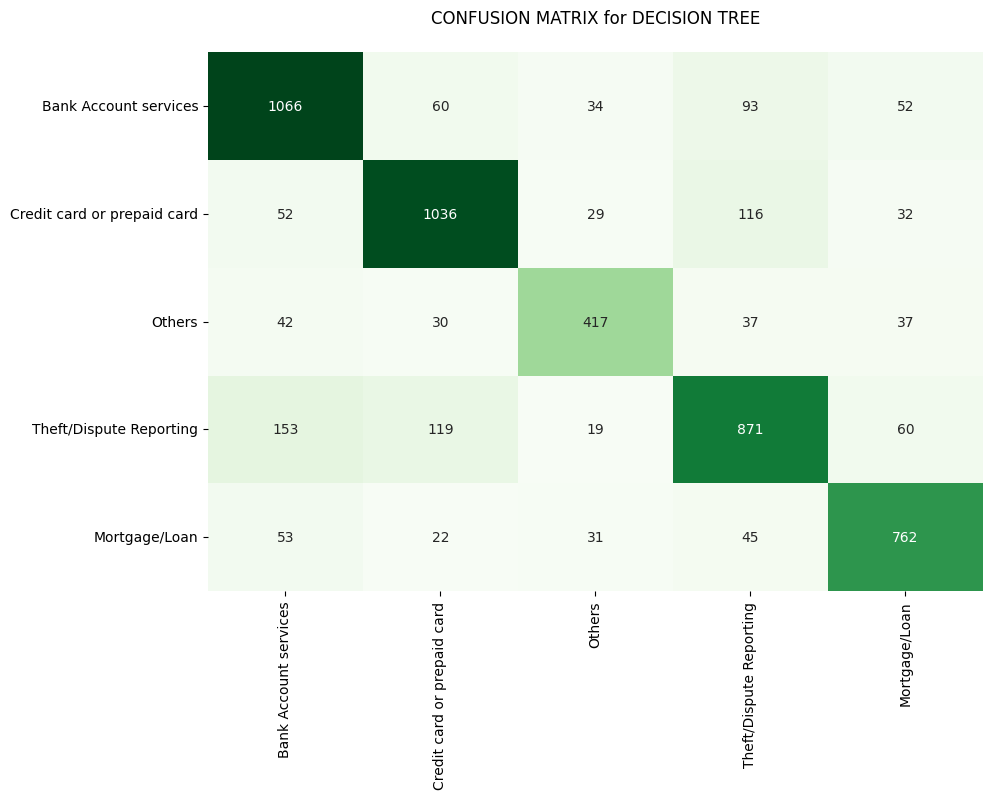

In [323]:
model_eval(y_test, y_pred_dt_tuned, model_name)

In [324]:
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.94
2,Decision Tree,0.79


## As per the F1 score of all the 3 models, Logistic Regression performs best with F1 score : 0.94

In [320]:
# Save Logistic Regression model
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

# Predicting topics using Logistic Regression on custom text

In [317]:
# Function to predict topic
def topic_predicter(text):

    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [318]:
# Create sample customer complaints
df_customer_complain = pd.DataFrame({'complaints': ["I am unable to access my online banking account despite multiple attempts.",
    "There is an unauthorized transaction on my debit card. Please investigate immediately.",
    "I need to change my address on my savings account. What is the process?",
    "My credit card payment due date is approaching. Can I extend it?",
    "How can I apply for a personal loan and what are the eligibility criteria?",
    "I lost my ATM card. How can I request a replacement?",
    "I want to know the interest rates for fixed deposits at your bank.",
    "Please provide details about the various insurance policies you offer.",
    "I am interested in opening a business account. What documents are required?",
    "How can I transfer funds to an international account?",
    "There is a discrepancy in my account statement. Please help me resolve it.",
    "What are the charges for issuing a new cheque book?",
    "I want to close my existing account. What is the procedure?",
    "How can I reset my online banking password?",
    "Is it possible to set up automatic bill payments through my account?",
    "What are the benefits of the premium credit card offered by your bank?",
    "How can I link my Aadhaar card to my bank account?",
    "I need a loan against my property. What is the process?",
    "My account has been locked due to multiple failed login attempts. How can I unlock it?",
    "What are the various investment options available with your bank?",
    "I received a suspicious email claiming to be from your bank. How should I proceed?",
    "Can you provide information about student loan options?",
    "I need to update my mobile number linked to my bank account.",
    "How can I dispute a charge on my credit card statement?",
    "What is the procedure to activate international transactions on my debit card?"]})
df_customer_complain

,complaints
0,I am unable to access my online banking account despite multiple attempts.
1,There is an unauthorized transaction on my debit card. Please investigate immediately.
2,I need to change my address on my savings account. What is the process?
3,My credit card payment due date is approaching. Can I extend it?
4,How can I apply for a personal loan and what are the eligibility criteria?
5,I lost my ATM card. How can I request a replacement?
6,I want to know the interest rates for fixed deposits at your bank.
7,Please provide details about the various insurance policies you offer.
8,I am interested in opening a business account. What documents are required?
9,How can I transfer funds to an international account?


In [321]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_customer_complain['predicted topic'] = df_customer_complain['complaints'].apply(lambda x: topic_predicter([x]))
df_customer_complain

,complaints,predicted topic
0,I am unable to access my online banking account despite multiple attempts.,Bank Account services
1,There is an unauthorized transaction on my debit card. Please investigate immediately.,Theft/Dispute Reporting
2,I need to change my address on my savings account. What is the process?,Bank Account services
3,My credit card payment due date is approaching. Can I extend it?,Others
4,How can I apply for a personal loan and what are the eligibility criteria?,Mortgage/Loan
5,I lost my ATM card. How can I request a replacement?,Credit card or prepaid card
6,I want to know the interest rates for fixed deposits at your bank.,Bank Account services
7,Please provide details about the various insurance policies you offer.,Mortgage/Loan
8,I am interested in opening a business account. What documents are required?,Bank Account services
9,How can I transfer funds to an international account?,Bank Account services


### Conclusion :  Logistic Regression model is predicting well on custom customer complaints